# Introduction

This report presents a series of inquiries pertaining to the "Example_Application_Dataset" provided by Falvey Insurance Group. The dataset consists of discrete and categorical data, comprised primarily of IDs and geographical information.

There is one large assumption motivating this report: a date that is absent from any of the date fields implies that the assured, by way of the specified broker, was never offered an insurance policy. That is to say, if an "applicationid" is missing either a quote date ("DateQuoteEntered") or a date on which a quote was bound ("DateQuoteBound"), then the application either is still pending or has been rejected.

This report was written in Python 3.8 and generated in LaTeX. I ommitted the lines of code to produce each output, but all the code used can be found in the Python Code file in this project folder on GitHub.

After familiarizing myself with the dataset, I chose to investigate the following queries:<br>
1. Top 10 broker groups with highest number of binding quotes.<br>
2. Top 10 broker cities with highest number of binding quotes.<br>
3. Comparison of applications and quotes received per year.<br>
4. Duration of days between application submission, provided quote, and binding quote.<br>
5. Interactive map of bound quotes and cities.<br>
6. Logistic regression to predict bound quote.

In [65]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

file = 'Example_Application_Dataset.xlsx'
xl = pd.ExcelFile(file)
print(xl.sheet_names)
data = xl.parse('Data')
# Remove Division since all are cargo.
data = data.drop('Division',1)

['Data', 'Data Definitions']


The column names are defined in the Excel spreadsheet and are shown again here:

In [66]:
# Col names
for col in data.columns:
    print(col) 

applicationid
AssuredID
BrokerOfficeID
application_EnteredDate
DateQuoteEntered
DateQuoteBound
Broker City
Broker State
Country
BrokerGroupID
UnderwriterID


Based on the aforementioned assumption, I created a subset of the data that excludes entries or rows without dates (in-process/rejected applications) or "bad" or missing data. All ID columns/variables must have an integer value; otherwise, the entries are deleted. For example, entries whose BrokerGroupID is "NONE/NA" are deleted.

In [67]:
# Create dataset without missing data
clean = data.dropna()
clean = clean[clean['BrokerGroupID'] != 'NONE/NA']
# Convert BrokerGroupID to 'int' data type
clean = clean.astype({'BrokerGroupID':'int'})

## Top 10 Broker Groups with Highest Number of Binding Quotes

The following chart shows the top 10 broker groups with the greatest number of binding quotes from 2018-2021. It also provides a sense of the upper scale of the total number of applications that are accepted just over 3 years. 

Text(0.5, 0, 'Total Number of Binding Quotes')

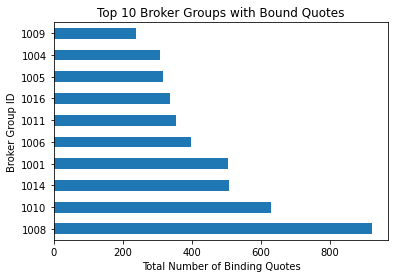

In [68]:
broker_group = clean['BrokerGroupID'].value_counts()
broker_group = broker_group.iloc[:10].plot(kind="barh")
broker_group.set_ylabel('Broker Group ID')
broker_group.set_title('Top 10 Broker Groups with Bound Quotes')
broker_group.set_xlabel('Total Number of Binding Quotes')

## Top 10 Broker Cities with Highest Number of Binding Quotes

Like the previous query, the chart below shows cities whose brokers have secured the highest number of binding quotes at the company. Query 5 in section 1.5 serves as a wider complement to this information.

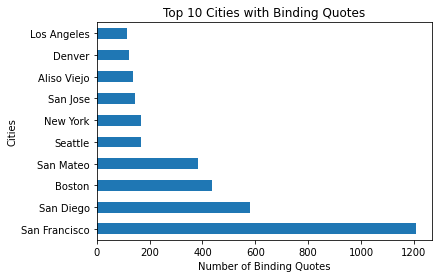

In [69]:
clean['Broker City'].value_counts()
city = clean['Broker City'].value_counts()
city_chart = city.iloc[:10].plot(kind="barh")
city_chart.set_ylabel('Cities')
city_chart.set_title('Top 10 Cities with Binding Quotes')
city_chart.set_xlabel('Number of Binding Quotes')
plt.show()

## Comparison of Applications and Quotes Received per Year

The graph below compares applications that were received, applications that were provided quotes, and quotes that were accepted by both the company (conditioned by the underwriter) and the broker/assured. The bars serve as a comparison between the yearly counts, with the labels above each bar representing the y-axis value.

From here, certain ratios can be calculated. For example, one interesting observation is that, despite over a 1000-applicant increase in 2020 over previous years, the ratio of binding quotes to applications received ultimately decreased (61% in 2018, 62% in 2019, and 57% in 2020).

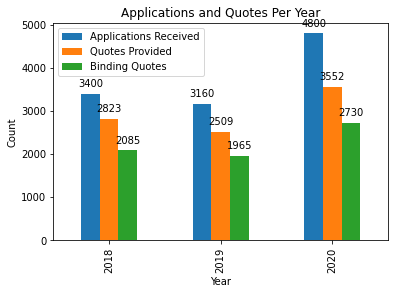

In [70]:
# Create 3 new dfs for enter date, quote date, and bound date.
# enter date df
enter_date = data[['application_EnteredDate', 'applicationid', 'AssuredID']].copy()
# consolidate by year and sum total number of applications for each year
enter_date = enter_date['application_EnteredDate'].groupby([enter_date.application_EnteredDate.dt.year]).agg('count')
# convert series to df
enter_date = enter_date.to_frame()
# rename index and column
enter_date.index.names = ['Year']
enter_date.columns = ['Applications Received']

# quote date df
quote_date = data[['DateQuoteEntered', 'applicationid', 'AssuredID']].copy()
# remove NAs
quote_date = quote_date.dropna()
# consolidate by year and sum total number of quotes provided per year.
quote_date = quote_date['DateQuoteEntered'].groupby([quote_date.DateQuoteEntered.dt.year]).agg('count')
# convert series to df
quote_date = quote_date.to_frame()
# rename index and column
quote_date.index.names = ['Year']
quote_date.columns = ['Quotes Provided']

# bound date df
bound_date = data[['DateQuoteBound', 'applicationid', 'AssuredID']].copy()
# remove NAs
bound_date = bound_date.dropna()
# consolidate by year and sum total number of applications for each year
bound_date = bound_date['DateQuoteBound'].groupby([bound_date.DateQuoteBound.dt.year]).agg('count')
# convert series to df
bound_date = bound_date.to_frame()
# rename index and column
bound_date.index.names = ['Year']
bound_date.columns = ['Binding Quotes']

# Merge all three dataframes and then plot
dates = [enter_date, quote_date, bound_date]
dates = reduce(lambda left,right: pd.merge(left,right,on='Year'), dates)
# append 2021 data for binding quotes
#dates = dates.append(bound_date.iloc[3])
# replace NAs with zero for 2021
#dates = dates.replace('NaN', 0)

# Plot the merged df
dates_plot = dates.plot(kind="bar")
dates_plot.set_ylabel('Count')
dates_plot.set_title('Applications and Quotes Per Year')
for p in dates_plot.patches:
    dates_plot.annotate(str(int(p.get_height())),(p.get_x()+p.get_width()/2.,p.get_height()),ha='center',va='center',xytext=(0, 10), textcoords='offset points')
plt.show()

## Duration of Days between Application Statuses

The table below is a quick statistical summary of the days between application statuses. The first column is the duration of an application received and a quote provided. The second column is the duration of a quote provided and a binding quote. The third column is the duration of an application received and a binding quote.

The idea here is to get a quick overview of the duration of the applications in days. Once again, we look only at applications that received a binding quote.

The "count" is the total number of applications with same-day processing (i.e., all three dates for each application are the same). Impressively, there is an average of 8 days once an application is received and a quote provided. As expected, the time between achieving a binding quote and application received or quote provided is much longer (nominally 4 times as long).

The outliers are interesting to look at, too. For example, from 2018 to 2020, the longest time from the date an application was received to a date a quote was bound was nearly 2.5 years. This table is useful for investigating outliers by cross referencing the "applicationid" in question.

Note that the min of -1 days is a result of the differences caused by the timestamp -- the minimum number of days is 0 for each application.

In [71]:
# calculate difference between two date columns as a new column
clean['Quote-Application-Duration'] = clean.DateQuoteEntered-clean.application_EnteredDate
clean['Binding-Quote-Duration'] = clean.DateQuoteBound-clean.DateQuoteEntered
clean['Binding-Application-Duration'] = clean.DateQuoteBound-clean.application_EnteredDate

# combine into new df
clean_duration = pd.DataFrame({'Quote-Application-Duration': clean['Quote-Application-Duration'], 'Binding-Quote-Duration': clean['Binding-Quote-Duration'], 'Binding-Application-Duration': clean['Binding-Application-Duration']})
#clean['Quote-Application-Duration'] = pd.to_datetime(clean['Quote-Application-Duration']).dt.date

# summary statistics of application and quote durations
clean_stats = clean_duration.describe()
clean_stats

,Quote-Application-Duration,Binding-Quote-Duration,Binding-Application-Duration
count,6247,6247,6247
mean,8 days 09:13:53.965903633,33 days 00:35:08.168881063,41 days 09:49:02.134784696
std,27 days 07:58:37.324457199,47 days 11:26:41.483782898,54 days 03:46:37.910931347
min,-1 days +08:52:00,-1 days +06:55:04,0 days 00:00:00
25%,0 days 00:00:00,11 days 14:08:19,15 days 16:12:31.500000
50%,0 days 00:00:00,22 days 08:55:58,29 days 10:11:57
75%,5 days 13:18:52,39 days 04:32:03,48 days 14:07:48
max,538 days 09:49:24,756 days 04:42:47,866 days 12:04:41


## Interactive Map of Bound Quotes and Cities

To mix it up a little bit, and because I find it so much easier to perform in Excel, I created a map showing the total number of bound quotes per year per city.

This map is a 3D map that I included in the Excel workbook ("Example_Application_Dataset_pivot"). I made a couple small tweaks to the Date Definitions sheet (for clarity). Again, I excluded applicationid entries with empty dates and removed entries where BrokerGroupID="NONE/NA". I also converted the Broker City and Broker State columns/variables to Excel's geography data type.

I created a pivot table, shown on the Pivot sheet, to create a table with specific conditions: columns are years 2018, 2019, and 2020; Broker City comprises the rows; and the values are DateQuoteBound. I copied this table to another worksheet, Yearly Bound Quotes, where I produced a 3D Map. This map can be viewed by going to the Insert tab, clicking "3D Map" from the dropdown menu, and selecting "Open 3D Maps".

The 3D map will open a new Excel window that is still linked to the workbook. My idea behind this map was to try to capture three notions quickly:
1. To view the geographic footprint of applications that received a binding quote per broker group.
2. To compare the total number of "complete" applications (those with a binding quote) per year.

This map is intended to provide a cursory look at the data to help answer questions such as, How did complete applications look for the brokers in Boston in 2020 compared to those in 2019? Are there other metropolitan areas in states where Falvey does not have a connection to a broker or broker group. For example, I could imagine investigating relationships with brokers in Madison, WI, which is the state's most populous city and which could benefit from Falvey Shippers Insurance.



## Logistic Regression to Predict Bound Quote

This final section is a quick exploratory analysis exercise on the dataset to clean statistical insights, as opposed to the visual information in prior sections. Simple methods, such as aPearson correlation matrix, cannot be used because we are looking at the relationship between categorical variables and binary. There are no continuous variables, and most of the categorical variables are multi-level. AChi-square test of independence of variables in a contingency would have been interesting, but there are simply too many categorical types in each variable, which could lead to unwieldy or unreliable results.

Instead, we will attempt to see if the dataset includes any predictive elements by way of logistic regression, which is a means to find the probability of a certain value. As mentioned, the dataset primarily consists of categorical variables and no continuous or binary variables. Logistic regression requires a response (dependent variable) that is binary. Our response variable here, or the variable we are looking to predict, is DateQuoteBound, which will need to undergo a primary conversion. If DateQuoteBound shows a date, then it will receive a value of 1; otherwise, no date equals 0. At this stage, we will also encode Broker City into categories (each unique city will be a unique number).

Here are the first 10 rows of the trimmed, converted dataset.


In [72]:
# remove NAs from BrokerGroupID column
data_trim = data[['applicationid', 'AssuredID', 'BrokerGroupID','DateQuoteBound','Broker City','UnderwriterID']].copy()
data_trim = data_trim[data_trim['BrokerGroupID'] != 'NONE/NA']
# convert DateQuoteBound to brinary. date exists = 1, NaN = 0
data_trim['DateQuoteBound'].loc[~data_trim['DateQuoteBound'].isnull()] = 1  # not nan
data_trim['DateQuoteBound'].loc[data_trim['DateQuoteBound'].isnull()] = 0   # nan
data_trim['DateQuoteBound'] = pd.to_numeric(data_trim['DateQuoteBound']) # convert new binary data to int type
# label encode Broker City
data_trim['Broker City'] = data_trim['Broker City'].astype('category') # convert variable to "category" type
data_trim['Broker City'] = data_trim['Broker City'].cat.codes # encode the variable using cat.codes accessor
data_trim.head() # first 10 rows of converted dataframe
#data_trim.dtypes

C:\Users\blubb\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,applicationid,AssuredID,BrokerGroupID,DateQuoteBound,Broker City,UnderwriterID
0,319838,2241,1002,0,234,8115.0
1,321405,2241,1002,0,234,8115.0
2,256240,5039,1007,1,43,8115.0
3,281979,5039,1007,1,43,8115.0
4,329088,5039,1007,1,43,8115.0


In [73]:
# Logistic regression using DateQuoteBound as response (dependent) variable
X = data_trim[['applicationid', 'AssuredID', 'BrokerGroupID','Broker City','UnderwriterID']]
X = X.dropna() # remove NAs
X = X.reset_index() # rest index to match y
del X['index']
y = data_trim['DateQuoteBound'] # reset index to match X
y.drop(y.tail(97).index,inplace = True) # delete rows to compensate for NAs deletion
y = y.reset_index()
del y['index']

First, we will generate a logit function to glean statistical information about a logistic regression model that is generated. According to the table below, the model iterated over the data only 5 times to optimize.

Notice that that the p-values of three variables, applicationid, Broker City, and UnderwriterID, is greater than 0.05. This indicates there is probably not a relationship between the variables and hence they will not contribute to the predictive accuracy of the model; they are potentially irrelevant. Thus, those variables will be excluded from the model.

This means only the AssuredID and BrokerGroupID are the variables used to predict the probability that there will be a bound quote.

In [74]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X.astype(float))
result=logit_model.fit()
print(result.summary2())
np.asarray(y)

Optimization terminated successfully.
         Current function value: 0.586391
         Iterations 5
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.106      
Dependent Variable: DateQuoteBound   AIC:              12120.1406 
Date:               2021-04-09 13:00 BIC:              12156.3527 
No. Observations:   10326            Log-Likelihood:   -6055.1    
Df Model:           4                LL-Null:          -6772.5    
Df Residuals:       10321            LLR p-value:      1.9811e-309
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     5.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
applicationid      0.0000   0.0000   1.5859 0.1128 -0.0000  0.0000
AssuredID         -0.0000   0.0000 -33.0516 0.0000 -0

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

With those variables removed, we can train a logistic regression model by splitting the data into test and training data. Here, I used 25% of the data for the test set, which a way to test the accuracy of the model. Again, the model is attempting to predict, with some degree of accuracy, the probability that a bound quote will be achieved based on the assured and broker group.

According to the results below, we achieved a model accuracy of 70%, meaning the model correctly assigned a bound quote to applications 70% of the time. The confusion matrix indicates that 400 + 1400 predictions are correct and 220 + 540 predictions are incorrect.

C:\Users\blubb\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy of logistic regression classifier on test set: 0.70


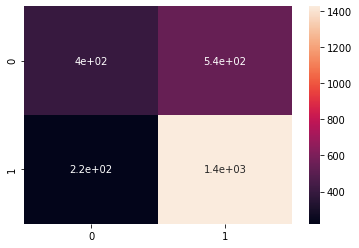

In [75]:
X = X[['AssuredID', 'BrokerGroupID']]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)
from sklearn.metrics import confusion_matrix
'''
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)'''
logistic_regression= LogisticRegression()
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)
sn.heatmap(confusion_matrix, annot=True)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
plt.show()

Finally, we will generate a receiver operating characteristic (ROC) curve, which is a common tool used with binary classifiers. The ROC simply uses different metrics to verify the accuracy of the model. Below, the dotted line represents the ROC curve of a random binary classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

Our concern rests on the desire for a high true positive rate and a low false positive rate. To quantitatively signify how "good" the blue curve is (i.e., how well , we look at the area under the curve, which is 0.64, meaning that the logistic regression model's predictions are 64% accurate. Whereas our computed accuracy of 70% was computed using fractions of correctly and incorrectly predicted outputs, the area under the ROC curve represents the probability that correct and incorrect predictions are sufficiently ranked.

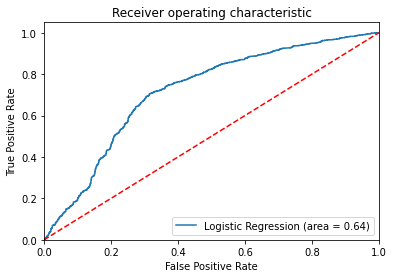

In [76]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Conclusion

This report sought to pose and answer 6 queries. The first 4 queries use minimal data manipulation techniques to glean high-level insights from the data. That is to say, they provide the viewer with quick "nuggets" of facts based on ratios, ranking, and overall performance of bound quotes versus applications received within the context of broker groups and cities.

Some interesting questions and observations arose as a result. For example, broker groups located in west-coast cities have the highest number of binding quotes with the company. In addition, despite an increase in applications, quotes provided, and quotes bound, the ratio of applications received to quotes bound has been roughly the same from 2018-2020. It is important to note that 2021 data were omitted from this report due their being only quote bound dates; no applications were submitted, and no quotes were provided in 2021, according to the dataset.

Similarly, the fifth query switches gears by looking at the Excel spreadsheet directly to generate an interactive, geographic map of the data to visualize broker groups located in cities primarily in the United States and the number of bound quotes assigned to them. It is intended to provide a cursory glance at the company's application footprint.

Finally, the sixth query takes a more in-depth approach by attempting to use the dataset to predict whether a bound quote could be predicted based on the assured and broker group. This required a bit more data manipulation for the data to be used in a classification model. Ultimately, we achieved a model accuracy of 70%, with an area under the ROC curve of 64%, suggesting that the model did an "OK" job at predicting the probability of an application achieving a bound quote. In order to improve this model, I would encourage more data (variables plus entries), as well as implementing more advanced, accurate classification techniques found in machine learning. Logistic regression is fast, easy, and mostly reliable, but there are more accurate techniques available.